### Import MNIST Data

In [27]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

# Write MNIST data locally, from request
if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

import pickle
import gzip

# Load request data into memory as numpy arrays
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_val, y_val), _) = pickle.load(f, encoding="latin-1")

import torch

# Convert numpy arrays into tensors
x_train, y_train, x_val, y_val = map(
    torch.tensor, (x_train, y_train, x_val, y_val)
)
n, c = x_train.shape

print(y_train)

tensor([5, 0, 4,  ..., 8, 4, 8])


### Plot A Sample Image

torch.Size([50000, 784])


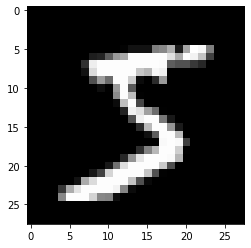

In [19]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

### OLD Models.py Code

In [20]:
from torch import nn
import torch.nn.functional as F

class Mnist_Logistic(nn.Module):

    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True) # Define a single, linear, layer

    def forward(self, xb):
        return self.lin(xb)

class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

### Training Helper Functions

In [21]:
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
import torch.nn.functional as F
import torch.nn as nn

# Calculate the loss for a single training batch
def calc_batch_loss(model, loss_func, xb, yb, opt=None):
    
    # Make predictions and get loss
    loss = loss_func(model(xb), yb)

    # Backpropagate if an optimizer is specified
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    # Return loss and length
    return loss.item(), len(xb)

# Fit an arbitrary model
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            calc_batch_loss(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[calc_batch_loss(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(epoch, val_loss)

# Returns DataLoader objects for fitting models, given training data, 
# validation data, and a training batch size
def get_dataloaders(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

# Helper function to create a pytorch model and optim (for doing gradient calculations)
def get_model_and_optimization(model = Mnist_Logistic()):
    return model, optim.SGD(model.parameters(), lr=lr)

# Lambda PyTorch Module that can be inserted into a "Sequential"
# object to perform arbitrary lambda operations on NN layers.
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

### MNIST Linear Model
This model is from the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html#switch-to-cnn).

In [22]:
bs = 64 # BATCH SIZE
lr = 0.5 # LEARNING RATE
num_epochs = 2
loss_func = F.cross_entropy

print(x_train.shape)
print(y_train.shape)
train_dataset = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_val, y_val)

train_dl, valid_dl = get_dataloaders(train_dataset, valid_ds, bs)
model, opt = get_model_and_optimization()
fit(num_epochs, model, loss_func, opt, train_dl, valid_dl)

torch.Size([50000, 784])
torch.Size([50000])
0 0.2982242438256741
1 0.4127650272130966


### MNIST CNN

In [23]:
import Models

lr = 0.1

x_train = x_train.float()

def preprocess_input(data):
    #print(f'Data shape: {data.shape}, and data sample: {data}.')
    data = data.view(-1, 1, 28, 28)
    #print(f'Data shape: {data.shape}, and data sample: {data}.')
    #print(f'Type: {data.dtype}')
    return data

model = nn.Sequential(
    Lambda(preprocess_input),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda X : X.view(X.size(0), -1)),
)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(num_epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.828952677154541
1 0.7509312322616577


In [25]:
import Data # Project data is loaded here
from torch.utils.data import DataLoader, TensorDataset # PyTorch DataLoader and TensorDatasets ;;;)
import torch
import numpy as np

from torch.nn import functional as F

# Define a split between training and validation data (since we were not provided with a separate validation dataset.)
# This split helps us calculate validation loss while experimenting with different trainign techniques. However, our final
# submission should be trained on all samples from the data we are given!
VAL_SPLIT = 25000

# Batch size is used to partition the training data into distinct batches which are used to train the CNN.
# Batch creation is facilitated by pytorch's DataLoader module :)
BATCH_SIZE = 64

# The number of epochs used to train the CNN.
EPOCHS = 10

# The loss function used during training
LOSS_FN = F.cross_entropy

# The learning rate used in the SGD that trains the CNN.
SGD_LEARNING_RATE = 0.1

# The momentum used in the SGD that trains the CNN.
SGD_MOMENTUM = 0.9

# Partition labeled data into train and val datasets
X_tmp = Data.labeled_images.reshape(-1, 3136)
y_tmp = Data.labels_as_unique_integers() # Binary to number/letter, then number/letter to unique integer represntation for each label (conv net is only happy with 1D numerical outputs)
X_val, y_val = X_tmp[VAL_SPLIT:], y_tmp[VAL_SPLIT:]
X_train, y_train = X_tmp[0:VAL_SPLIT], y_tmp[0:VAL_SPLIT]
print(f'X_train: {X_train.shape} \ny_train: {y_train.shape}')
print(f'X_val: {X_val.shape} \ny_val: {y_val.shape}')

# Transform the labeled train and val datasets into pytorch Tensors
X_train, y_train, X_val, y_val = map(
    torch.tensor, (X_train, y_train, X_val, y_val)
)

print(f'X_train tensor: {X_train} \ny_train tensor: {y_train}')

# Initialize pytorch TensorDatasets
train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)

# Initialize pytorch DataLoaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # Shuffled to prevent correlation betwen batch ordering and model overfitting, see: https://pytorch.org/tutorials/beginner/nn_tutorial.html#add-validation
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)


X_train: (25000, 3136) 
y_train: (25000,)
X_val: (5000, 3136) 
y_val: (5000,)
X_train tensor: tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0., 255.,   0.,  ...,   0.,   0.,   0.]], dtype=torch.float64) 
y_train tensor: tensor([904, 516, 808,  ..., 515, 205, 124], dtype=torch.int32)


In [26]:
lr = 0.1

x_train = x_train.float()

def preprocess_input(data):
    #print(f'Data shape: {data.shape}, and data sample: {data}.')
    data = data.view(-1, 1, 28, 28)
    #print(f'Data shape: {data.shape}, and data sample: {data}.')
    #print(f'Type: {data.dtype}')
    return data

model = nn.Sequential(
    Lambda(preprocess_input),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda X : X.view(X.size(0), -1)),
)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(num_epochs, model, loss_func, opt, train_dl, valid_dl)

RuntimeError: expected scalar type Double but found Float